In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [2]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

In [3]:
POPULATION = 8804190

In [4]:
df_cases_by_day = pd.read_csv("./coronavirus-data/trends/cases-by-day.csv")
df_cases_by_day['date_of_interest'] = pd.to_datetime(df_cases_by_day['date_of_interest'])

df_doses_by_day = pd.read_csv("covid-vaccine-data-main\doses\doses-by-day.csv")
df_doses_by_day["DATE"] = pd.to_datetime(df_doses_by_day["DATE"])

In [5]:
df_new_infec = df_cases_by_day[['date_of_interest','CASE_COUNT']]
df_new_infec.rename(columns={'date_of_interest':'date', 'CASE_COUNT':'case'},inplace=True)

df_doses_by_day['full_vac_rate'] = df_doses_by_day.ADMIN_DOSE2_CUMULATIVE.div(POPULATION)

df_full_vac = df_doses_by_day[['DATE', 'full_vac_rate']]
df_full_vac.rename(columns={'DATE':'date'},inplace=True)

C:\Python39\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


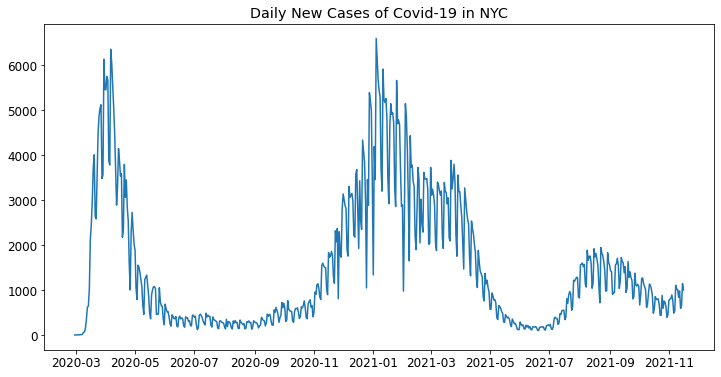

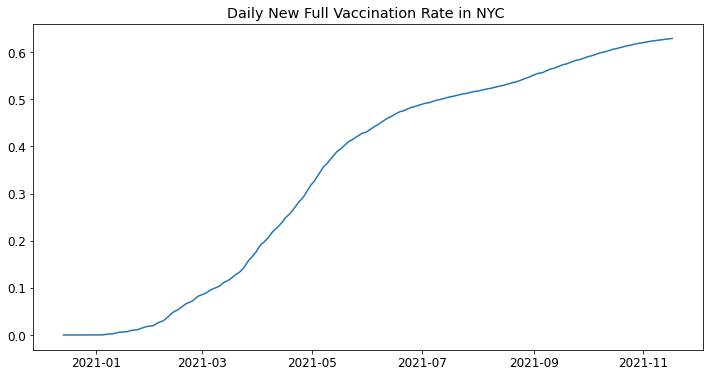

In [6]:
fig = plt.figure(figsize=(12,6))
plt.plot(df_cases_by_day.date_of_interest, df_cases_by_day.CASE_COUNT)
plt.title("Daily New Cases of Covid-19 in NYC")
plt.savefig("./first_report/full_cases.png")
plt.show()

fig = plt.figure(figsize=(12,6))
plt.plot(df_doses_by_day.DATE, df_doses_by_day.full_vac_rate)
plt.title("Daily New Full Vaccination Rate in NYC ")
plt.savefig("./first_report/vaccine_rate.png")
plt.show()

In [7]:
vac_i = df_full_vac.date.min()
vac_f = df_full_vac.date.max()

inf_i = df_new_infec.date.min()
inf_f = df_new_infec.date.max()

date_i = max(vac_i, inf_i)
date_f = min(vac_f, inf_f)
print(date_i)

2020-12-14 00:00:00


In [8]:
df_full_vac = df_full_vac[(df_full_vac.date>=date_i)&(df_full_vac.date<=date_f)]
df_new_infec = df_new_infec[(df_new_infec.date>=date_i)&(df_new_infec.date<=date_f)]

df_case_n_vac = pd.merge(df_new_infec, df_full_vac, on='date')

In [9]:
df_case_n_vac.head()

,date,case,full_vac_rate
0,2020-12-14,3577,0.000000e+00
1,2020-12-15,3679,3.407468e-07
2,2020-12-16,2784,1.930899e-06
3,2020-12-17,1924,3.861798e-06
4,2020-12-18,3428,6.587772e-06


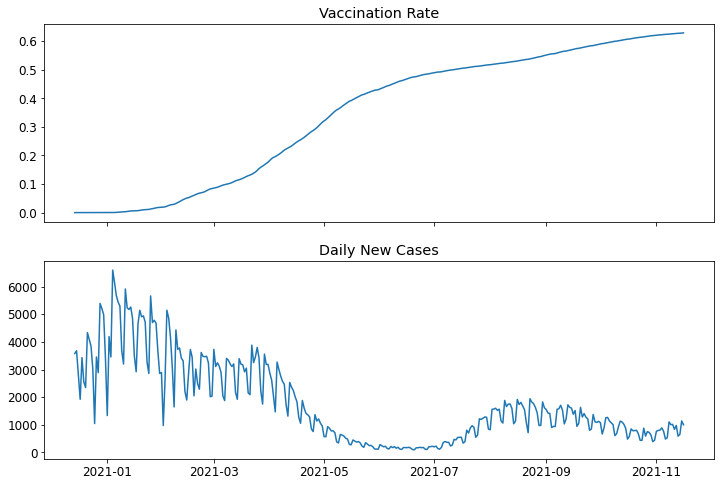

In [10]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axs[0,].plot(df_case_n_vac.date, df_case_n_vac.full_vac_rate)
axs[0,].set_title("Vaccination Rate")
axs[1,].plot(df_case_n_vac.date, df_case_n_vac.case)
axs[1,].set_title("Daily New Cases")

plt.savefig("./first_report/vacc_n_case_same_period.png")

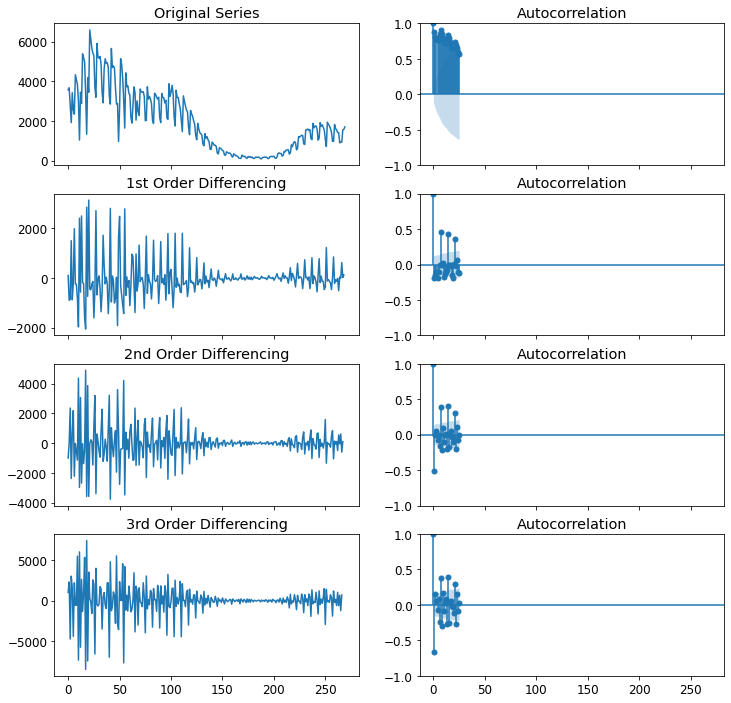

In [11]:
val = df_case_n_vac.case.values

train_test_split = int(len(val)*0.8)
train = val[:train_test_split]
test = val[train_test_split:]

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(12,12))
axes[0, 0].plot(train); axes[0, 0].set_title('Original Series')
plot_acf(train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(train)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(train), ax=axes[1, 1])
diffval = np.diff(train)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
diffdiffval = np.diff(diffval)

axes[3, 0].plot(np.diff(diffdiffval)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diffdiffval), ax=axes[3, 1])
plt.savefig("./first_report/diff_case.png")
plt.show()


In [12]:
model = pm.auto_arima(train, start_p=7, start_q=7,
test='adf', # use adftest to find optimal 'd'
max_p=7, max_q=7, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=True, 
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(7,1,7)(0,0,0)[0] intercept   : AIC=4187.002, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4328.213, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4320.137, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4292.876, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4326.238, Time=0.01 sec
 ARIMA(6,1,7)(0,0,0)[0] intercept   : AIC=4183.363, Time=2.11 sec
 ARIMA(5,1,7)(0,0,0)[0] intercept   : AIC=4165.900, Time=2.12 sec
 ARIMA(4,1,7)(0,0,0)[0] intercept   : AIC=4160.900, Time=1.85 sec
 ARIMA(3,1,7)(0,0,0)[0] intercept   : AIC=4204.859, Time=1.25 sec
 ARIMA(4,1,6)(0,0,0)[0] intercept   : AIC=4183.705, Time=1.47 sec
 ARIMA(3,1,6)(0,0,0)[0] intercept   : AIC=4179.831, Time=1.43 sec
 ARIMA(5,1,6)(0,0,0)[0] intercept   : AIC=4192.493, Time=1.67 sec
 ARIMA(4,1,7)(0,0,0)[0]             : AIC=4157.891, Time=1.67 sec
 ARIMA(3,1,7)(0,0,0)[0]             : AIC=4201.536, Time=1.11 sec
 ARIMA(4,1,6)(0,0,0)[0]          

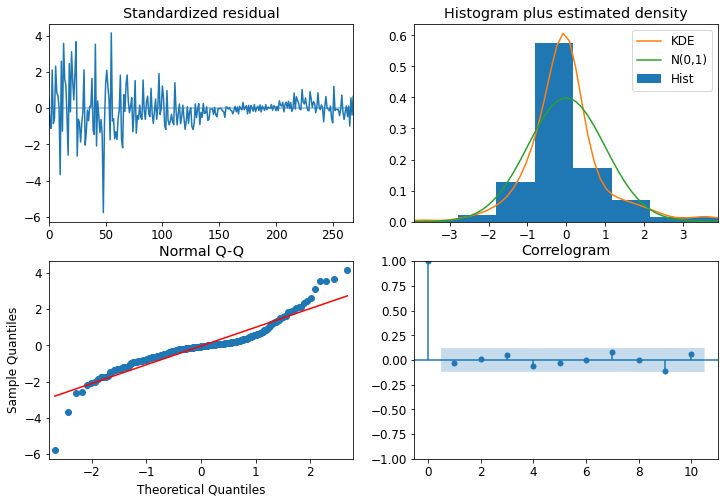

In [13]:
model.plot_diagnostics(figsize=(12,8))
plt.savefig("./first_report/diag_case.png")
plt.show()

In [14]:
np.concatenate([np.array([1,2]),np.array([3,4])])

array([1, 2, 3, 4])

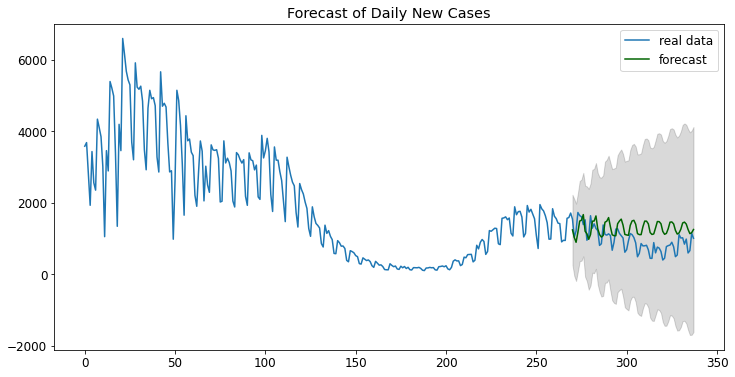

In [15]:
# Forecast
n_periods = len(test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(train), len(train)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig = plt.figure(figsize=(12,6))
plt.plot(val, label='real data')
plt.plot(fc_series, color='darkgreen', label="forecast")
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='k', alpha=.15)
plt.title("Forecast of Daily New Cases")
plt.legend()
plt.savefig("./first_report/forecast_case.png")
plt.show()

In [16]:
fc.mean()

1283.065176028335

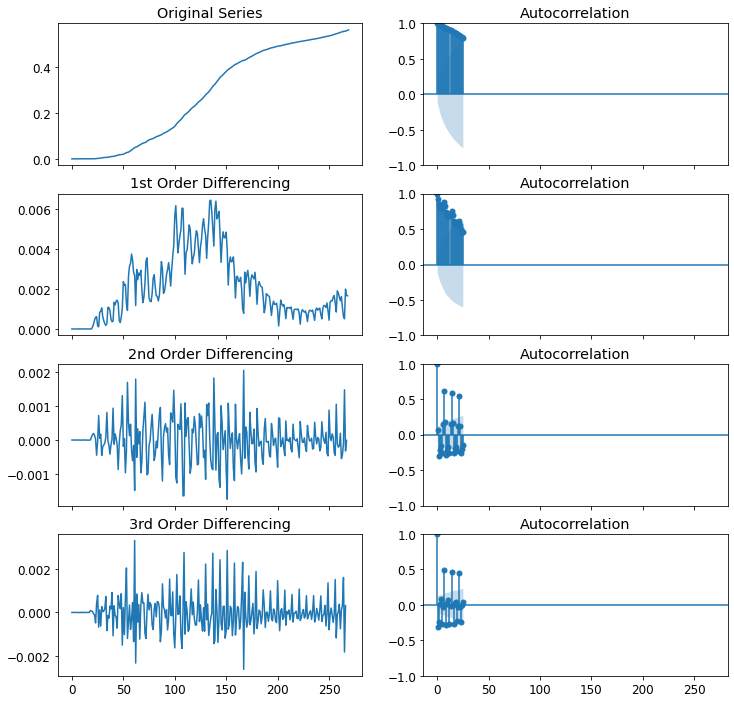

In [17]:
val = df_case_n_vac.full_vac_rate.values

train_test_split = int(len(val)*0.8)
train = val[:train_test_split]
test = val[train_test_split:]

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(12,12))
axes[0, 0].plot(train); axes[0, 0].set_title('Original Series')
plot_acf(train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(train)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(train), ax=axes[1, 1])
diffval = np.diff(train)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
diffdiffval = np.diff(diffval)

axes[3, 0].plot(np.diff(diffdiffval)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diffdiffval), ax=axes[3, 1])
plt.savefig("./first_report/diff_vacc.png")
plt.show()

In [18]:
model = pm.auto_arima(train, start_p=7, start_q=7,
test='adf', # use adftest to find optimal 'd'
max_p=7, max_q=7, # maximum p and q
m=1, # frequency of series
d=2, # let model determine 'd'
seasonal=False, 
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(7,2,7)(0,0,0)[0] intercept   : AIC=-3385.339, Time=1.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-3215.358, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-3214.431, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-3214.158, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3217.329, Time=0.03 sec
 ARIMA(6,2,7)(0,0,0)[0] intercept   : AIC=-3386.337, Time=1.61 sec
 ARIMA(5,2,7)(0,0,0)[0] intercept   : AIC=-3394.197, Time=1.86 sec
 ARIMA(4,2,7)(0,0,0)[0] intercept   : AIC=-3382.949, Time=1.41 sec
 ARIMA(5,2,6)(0,0,0)[0] intercept   : AIC=-3378.106, Time=1.46 sec
 ARIMA(4,2,6)(0,0,0)[0] intercept   : AIC=-3362.133, Time=1.22 sec
 ARIMA(6,2,6)(0,0,0)[0] intercept   : AIC=-3379.764, Time=1.54 sec
 ARIMA(5,2,7)(0,0,0)[0]             : AIC=-3396.453, Time=0.58 sec
 ARIMA(4,2,7)(0,0,0)[0]             : AIC=-3383.059, Time=0.17 sec
 ARIMA(5,2,6)(0,0,0)[0]             : AIC=-3381.524, Time=0.69 sec
 ARIMA(6,2,7)(0,0,0

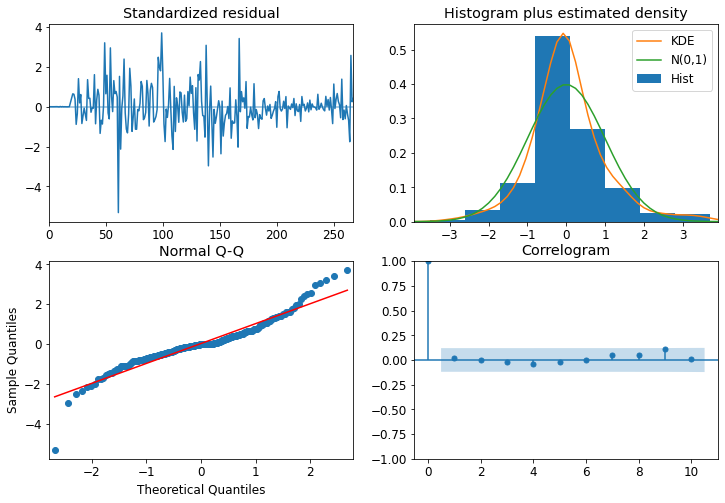

In [19]:
model.plot_diagnostics(figsize=(12,8))
plt.savefig("./first_report/diag_vacc.png")
plt.show()

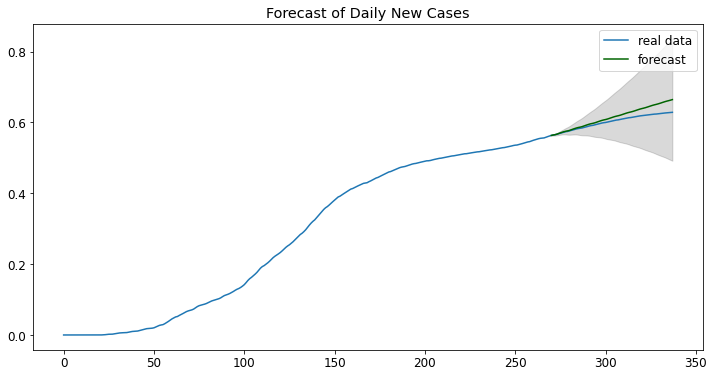

In [20]:
# Forecast
n_periods = len(test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(train), len(train)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig = plt.figure(figsize=(12,6))
plt.plot(val, label='real data')
plt.plot(fc_series, color='darkgreen', label="forecast")
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='k', alpha=.15)
plt.title("Forecast of Daily New Cases")
plt.legend()
plt.savefig("./first_report/forecast_vacc.png")
plt.show()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [22]:
def find_criticals(df, arr, default, date_name, num_std):
    filter = abs(arr - np.mean(arr)) > (num_std*np.std(arr))
    critical_indices = np.where(filter)[0]+default
    critical_dates = np.array(df[date_name].to_list())[critical_indices]

    return critical_dates


def calculate_critical_dates(df, period, variable_name, date_name, method, start, end, num_std, df_name):
    if method == 'diff':
        diff_list = df[variable_name].diff(periods=period).to_list()
    elif method == 'regression':
        model = LinearRegression()
        X = [i for i in range(len(df))]
        X = np.reshape(X, (len(X),1))
        model.fit(X, df[variable_name])
        trend = model.predict(X)
        y = df[variable_name].to_list()
        diff_list = [trend[i]-y[i] for i in range(len(y))]
        
    default = 0
    for i,num in enumerate(diff_list):
        if not np.isnan(num):
            default = i
            break
    diff_list = diff_list[default:]

    arr = np.array(diff_list).astype(np.float64)

    critical_dates = find_criticals(df, arr, default, date_name, num_std)

    time_list = df[variable_name].to_list()
    time_series = pd.Series(time_list, index = df[date_name])

    fig = plt.figure(figsize=(16,6))
    plt.plot(df[date_name],df[variable_name])

    for dot in critical_dates:
        plt.scatter(dot, time_series[dot], color='r')
    # plt.axvline(pd.to_datetime(start), color='purple', lw=2)
    # plt.axvline(pd.to_datetime(end), color='purple', lw=2)
    plt.xlim(pd.Timestamp(start),pd.Timestamp(end))
    
    plt.title("{} Satistics with Critical Dates".format(df_name))
    plt.show()

    return critical_dates, time_series


def plot_with_critical_dates(critical_dates,time_series,variable_name, color, linestyle):    
    time_series.plot(label=variable_name, linestyle=linestyle)
    for dot in critical_dates:
        plt.scatter(dot, time_series[dot], c=color)

In [23]:
date_i

Timestamp('2020-12-14 00:00:00')

In [24]:
date_f

Timestamp('2021-11-16 00:00:00')

In [25]:
df_case_n_vac.columns

Index(['date', 'case', 'full_vac_rate'], dtype='object')

In [26]:
df_case_n_vac['case_smoothed'] = df_case_n_vac['case'].rolling(window=7).mean()

In [27]:
df_case_n_vac['vacc_smoothed'] = df_case_n_vac['full_vac_rate'].rolling(window=7).mean()

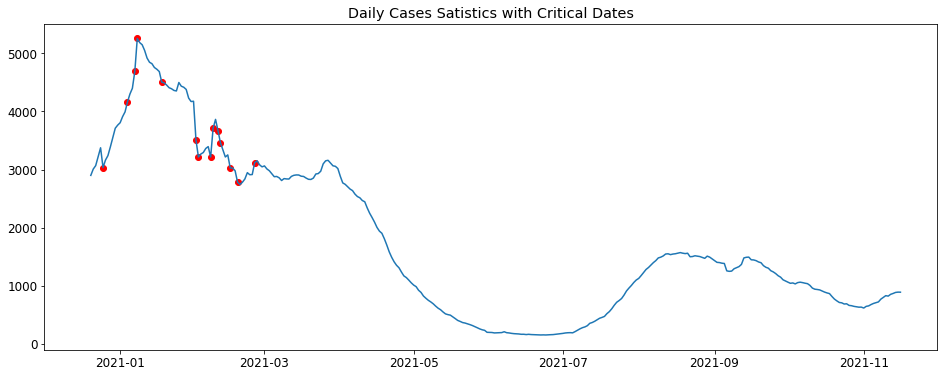

In [28]:
critical_date_case, time_series_case = calculate_critical_dates(df_case_n_vac, period=1,variable_name='case_smoothed', date_name='date',\
    method='diff',start='2020-12-01',end='2021-12-01',num_std=2, df_name="Daily Cases")

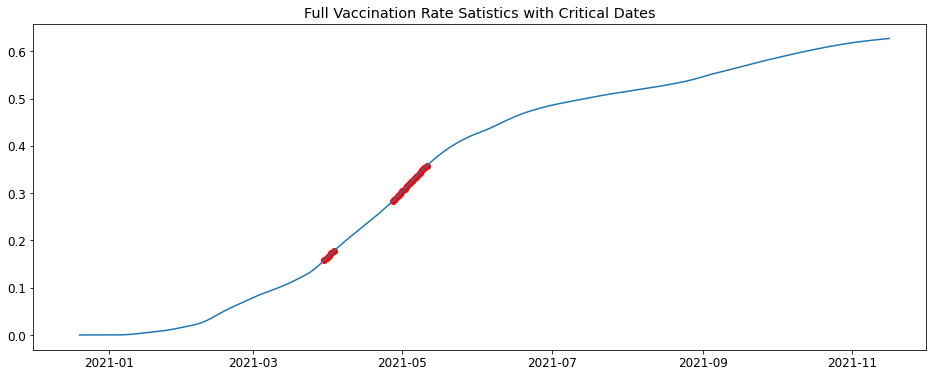

In [29]:
critical_date_vacc, time_series_vacc = calculate_critical_dates(df_case_n_vac, period=1,variable_name='vacc_smoothed', date_name='date',\
    method='diff',start='2020-12-01',end='2021-12-01',num_std=2, df_name="Full Vaccination Rate")

In [30]:
case_ts = pd.Series(data=df_case_n_vac.case.values, index=df_case_n_vac.date)

In [31]:
case_ts

date
2020-12-14    3577
2020-12-15    3679
2020-12-16    2784
2020-12-17    1924
2020-12-18    3428
              ... 
2021-11-12     978
2021-11-13     590
2021-11-14     656
2021-11-15    1142
2021-11-16    1001
Length: 338, dtype: int64

In [32]:
case_ts.shift(periods=1)

date
2020-12-14       NaN
2020-12-15    3577.0
2020-12-16    3679.0
2020-12-17    2784.0
2020-12-18    1924.0
               ...  
2021-11-12     837.0
2021-11-13     978.0
2021-11-14     590.0
2021-11-15     656.0
2021-11-16    1142.0
Length: 338, dtype: float64

In [33]:
def make_shift_table(ts, num, name):
    index = ts.keys()
    context = {}
    for i in range(num):
        context[name+"_"+str(i)+"_shift"] = ts.shift(periods=i)
    
    return pd.DataFrame(data=context, index=index).iloc[num-1:,:]

In [34]:
case_shift = make_shift_table(case_ts, 5, "case")

In [35]:
vacc_ts = pd.Series(data=df_case_n_vac.full_vac_rate.values, index=df_case_n_vac.date)

In [36]:
vacc_shift = make_shift_table(vacc_ts, 6, "vacc")

In [37]:
case_n_vacc_shift = pd.merge(case_shift, vacc_shift, on='date')

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
case_n_vacc_shift

,case_0_shift,case_1_shift,case_2_shift,case_3_shift,case_4_shift,vacc_0_shift,vacc_1_shift,vacc_2_shift,vacc_3_shift,vacc_4_shift,vacc_5_shift
date,,,,,,,,,,,
2020-12-19,2555,3428.0,1924.0,2784.0,3679.0,0.000007,0.000007,0.000004,0.000002,3.407468e-07,0.000000e+00
2020-12-20,2348,2555.0,3428.0,1924.0,2784.0,0.000007,0.000007,0.000007,0.000004,1.930899e-06,3.407468e-07
2020-12-21,4335,2348.0,2555.0,3428.0,1924.0,0.000009,0.000007,0.000007,0.000007,3.861798e-06,1.930899e-06
2020-12-22,4097,4335.0,2348.0,2555.0,3428.0,0.000012,0.000009,0.000007,0.000007,6.587772e-06,3.861798e-06
2020-12-23,3844,4097.0,4335.0,2348.0,2555.0,0.000017,0.000012,0.000009,0.000007,7.269266e-06,6.587772e-06
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-12,978,837.0,1015.0,1008.0,1105.0,0.626690,0.626063,0.625486,0.624895,6.243032e-01,6.236760e-01
2021-11-13,590,978.0,837.0,1015.0,1008.0,0.627092,0.626690,0.626063,0.625486,6.248952e-01,6.243032e-01
2021-11-14,656,590.0,978.0,837.0,1015.0,0.627348,0.627092,0.626690,0.626063,6.254864e-01,6.248952e-01


In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
for column in case_n_vacc_shift.columns.values:
    trans = MinMaxScaler()
    result = trans.fit_transform(case_n_vacc_shift[column].to_numpy().reshape(-1,1))
    case_n_vacc_shift[column] = result.reshape(-1)

In [42]:
case_n_vacc_shift

,case_0_shift,case_1_shift,case_2_shift,case_3_shift,case_4_shift,vacc_0_shift,vacc_1_shift,vacc_2_shift,vacc_3_shift,vacc_4_shift,vacc_5_shift
date,,,,,,,,,,,
2020-12-19,0.378387,0.512777,0.281250,0.413639,0.551416,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2020-12-20,0.346521,0.378387,0.512777,0.281250,0.413639,3.614285e-07,0.000001,0.000004,0.000003,0.000003,5.442690e-07
2020-12-21,0.652401,0.346521,0.378387,0.512777,0.281250,3.072142e-06,0.000001,0.000005,0.000007,0.000006,3.084191e-06
2020-12-22,0.615764,0.652401,0.346521,0.378387,0.512777,7.409284e-06,0.000004,0.000006,0.000009,0.000010,6.168382e-06
2020-12-23,0.576817,0.615764,0.652401,0.346521,0.378387,1.499928e-05,0.000009,0.000009,0.000009,0.000011,1.052253e-05
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-12,0.135622,0.113916,0.141318,0.140240,0.155172,9.970789e-01,0.996927,0.997033,0.996497,0.996191,9.961869e-01
2021-11-13,0.075893,0.135622,0.113916,0.141318,0.140240,9.977179e-01,0.997925,0.997953,0.997440,0.997136,9.971887e-01
2021-11-14,0.086053,0.075893,0.135622,0.113916,0.141318,9.981251e-01,0.998564,0.998952,0.998360,0.998079,9.981342e-01


In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_df = case_n_vacc_shift.drop(columns=['case_0_shift', 'vacc_0_shift'])
X = X_df.to_numpy()

In [45]:
y = case_n_vacc_shift.case_0_shift.values

In [46]:
X.shape

(333, 9)

In [47]:
y = y.reshape(-1,1)
y.shape

(333, 1)

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
LR = LinearRegression().fit(X_train,y_train)

In [51]:
coefficients = LR.coef_.reshape(-1)

In [52]:
coefficients

array([  0.6805508 ,  -0.04721446,   0.16249936,  -0.02104215,
       -11.64843446,   2.97446595,  14.95698371,   0.44767481,
        -6.83649333])

In [53]:
X_df.columns.values

array(['case_1_shift', 'case_2_shift', 'case_3_shift', 'case_4_shift',
       'vacc_1_shift', 'vacc_2_shift', 'vacc_3_shift', 'vacc_4_shift',
       'vacc_5_shift'], dtype=object)

In [54]:
pd.DataFrame({'variable_names': X_df.columns.values, 'coefficients':coefficients})

,variable_names,coefficients
0,case_1_shift,0.680551
1,case_2_shift,-0.047214
2,case_3_shift,0.162499
3,case_4_shift,-0.021042
4,vacc_1_shift,-11.648434
5,vacc_2_shift,2.974466
6,vacc_3_shift,14.956984
7,vacc_4_shift,0.447675
8,vacc_5_shift,-6.836493


In [55]:
LR.score(X_test,y_test)

0.7780283510268707

In [56]:
X_df.iloc[:,:4]

,case_1_shift,case_2_shift,case_3_shift,case_4_shift
date,,,,
2020-12-19,0.512777,0.281250,0.413639,0.551416
2020-12-20,0.378387,0.512777,0.281250,0.413639
2020-12-21,0.346521,0.378387,0.512777,0.281250
2020-12-22,0.652401,0.346521,0.378387,0.512777
2020-12-23,0.615764,0.652401,0.346521,0.378387
...,...,...,...,...
2021-11-12,0.113916,0.141318,0.140240,0.155172
2021-11-13,0.135622,0.113916,0.141318,0.140240
2021-11-14,0.075893,0.135622,0.113916,0.141318


In [57]:
LR = LinearRegression().fit(X_train[:,:4],y_train)

In [58]:
LR.score(X_test[:,:4],y_test)

0.7219018159816197